# Fictitious Play

# 2 - Monte Carlo

Recall that Monte Carlo sampling allows us to estimate the expectation of a random function by sampling from the corresponding probability distribution.

More precisely, if $f(x)$ is a 1-dimensional (continuous) probability density, and $X ∼ f$ is a stochastic variable distributed according to this density $f$, then the expected value of some function $\phi$ can be estimated using Monte Carlo sampling by:
$$

$$

## 2.1 Estimation

In [1]:
import numpy as np

sample_size = 10000
X = np.random.randn(sample_size, 1) # random sample from N(0,1) population
F = np.cos(X)**2 # compute function value at each sample 

# Compute the Monte Carlo estimate for m = E((cos(X))^2) by computing the sample average
# i.e., The MC estimate for m = E((cos(X))^2) is obtained by computing the sample average:
m_mc = np.mean(F)

# Compute the standard deviation for the sample mean
m_mc_std = np.std(F) / np.sqrt(sample_size)

print("Monte Carlo estimate:", m_mc)
print("Standard deviation for the sample mean:", m_mc_std)


Monte Carlo estimate: 0.5690781299520837
Standard deviation for the sample mean: 0.0034802080882795354


**Conclusion**. Based on the above matlab code we conclude that $E(\cos^{2}(X)) \approx 0.5665$ (based on $10000$ MC samples). 

Since the standard error (standard deviation for sample mean) equals $0.003$ (approximately), we estimate the accuracy on the result as $3 × 0.003 \approx 0.01$. Hence we conclude:
$$E(\cos^{2}(X)) ≈ 0.57 \pm 0.01$$

PS: An accurate numerical integration yields the value $0.567667642$.

## 2.2 Quantifying the significance of an observed correlation

Suppose you’re designing a deep neural network that **needs to maximize some score function** $S$. 

The actual design of the network depends on some **hyperparameter** $A$. 

Training the networks is computationally very demanding and time consuming, and as a consequence you have only been able to **perform 10 experiments** to date. 

Based on these ten data points you observe a slight positive correlation of $0.3$ between the value of the hyperparameter $A$ and the score $S$. 
- If this result is genuine, it suggests to increase $A$ in the next experiment in order to improve the score. 
- But if the correlation is not significant, increasing $A$ could lead you astray. How would you use MC to decide whether the correlation is significant?

Hint: Compute the simulated p-value of the observed result, under the assumption of independence.

In [20]:
import numpy as np

# We have 10 data points for which the observed correlation equals r_obs = 0.3.
r_obs = 0.3
n = 10  # number of experimental data points

# Assume that there is no correlation between the two parameters,
# then the observed correlation is a random fluctuation.
# To test how likely this size of fluctuation is, we generate independent variables
# and tally how often a correlation of r_obs (or larger) is observed.
nr_samples = 1000
Rho_MC = np.zeros(nr_samples)

for i in range(nr_samples):
    # Generated randomly distributed but independent samples for S and A
    S = np.random.randn(n)
    A = np.random.randn(n)

    # Compute and store the observed correlation coef for each sample
    Rho = np.corrcoef(A, S)  # full correlation matrix
    Rho_MC[i] = Rho[0, 1]    # correlation between variables 1 and 2 in corr matrix

# Compute the p-value of the observed value
pval = np.sum(Rho_MC > r_obs) / nr_samples

print("P-value:", pval)

P-value: 0.198


two independent samples

essentially calculating p values, not with tables but with simulations

simulation replacing t-tests.

## 2.3 Kullback-Leibler Divergence

The Kullback-Leibler (KL) divergence quantifies the similarity (or more precisely, the dissimilarity) of two probability densities. More specifically, given two continuous (1-dim) probability densities f, g, the KL-divergence is defined as:

In [21]:
import numpy as np
from scipy.stats import norm

# f ~ N(mu1, sigma1^2)
mu1, sigma1 = 0, 2

# g ~ N(mu2, sigma2^2)
mu2, sigma2 = 2, 3

sample_size = 1000

# Sample from f and compute the KL value at each sample point
X = mu1 + sigma1 * np.random.randn(sample_size)
KL = np.log(norm.pdf(X, mu1, sigma1) / norm.pdf(X, mu2, sigma2))
KL_div = np.mean(KL)  # KL divergence
KL_div_std = np.std(KL) / np.sqrt(sample_size)

# KL divergence based on theoretical expression
KL_div_theory = np.log(sigma2 / sigma1) + (sigma1**2 + (mu1 - mu2)**2) / (2 * sigma2**2) - 1 / 2

print("KL divergence (empirical):", KL_div)
print("Standard deviation for the sample KL divergence:", KL_div_std)
print("KL divergence (theoretical):", KL_div_theory)


KL divergence (empirical): 0.35481654054914286
Standard deviation for the sample KL divergence: 0.017727672082131822
KL divergence (theoretical): 0.3499095525526088


## 2.4

# Exploitation versus Exploration

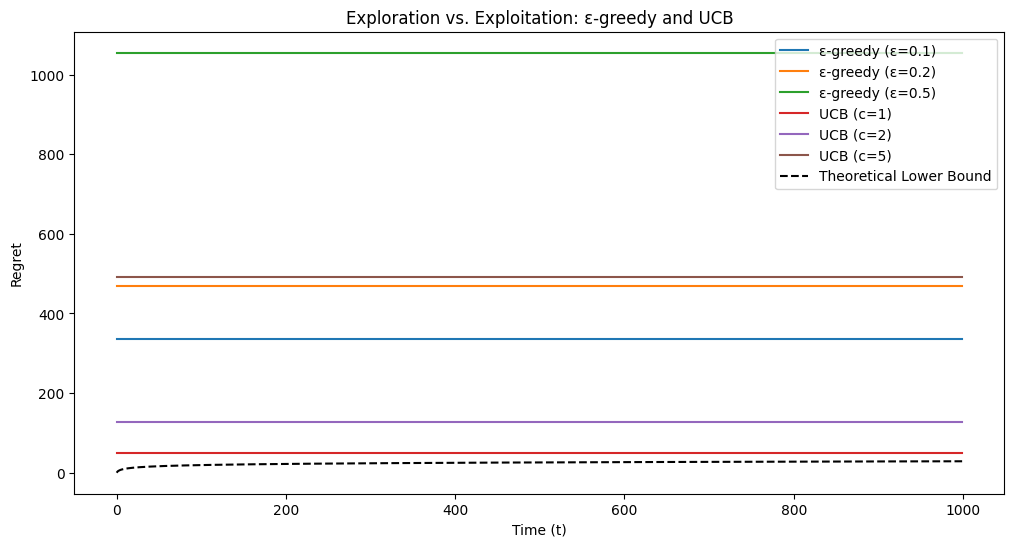

ε-greedy (ε=0.1): 57.90% correct decisions
ε-greedy (ε=0.2): 76.20% correct decisions
ε-greedy (ε=0.5): 54.70% correct decisions
UCB (c=1): 93.30% correct decisions
UCB (c=2): 91.90% correct decisions
UCB (c=5): 60.50% correct decisions


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Number of arms
k = 10

# Number of total actions
T = 1000

# Number of experiments
num_experiments = 100

# Generate true means for each arm (randomly)
true_means = np.random.normal(size=k)

def epsilon_greedy(Q, epsilon):
    if np.random.rand() < epsilon:
        # Exploration: choose a random arm
        return np.random.choice(k)
    else:
        # Exploitation: choose the arm with the highest estimated mean
        return np.argmax(Q)

def UCB(Q, c, t, N):
    # Upper Confidence Bound strategy
    exploration_bonus = c * np.sqrt(np.log(t + 1) / (N + 1e-6))
    return np.argmax(Q + exploration_bonus)

# Function to run a single experiment
def run_experiment(epsilon, c):
    Q = np.zeros(k)  # Estimated means
    N = np.zeros(k)  # Number of times each arm is pulled
    total_regret = 0
    correct_decisions = 0

    for t in range(1, T + 1):
        # Choose arm based on strategy
        if epsilon is not None:
            chosen_arm = epsilon_greedy(Q, epsilon)
        else:
            chosen_arm = UCB(Q, c, t, N)

        # Simulate reward from chosen arm
        reward = np.random.normal(true_means[chosen_arm])

        # Update estimates and counts
        N[chosen_arm] += 1
        Q[chosen_arm] += (reward - Q[chosen_arm]) / N[chosen_arm]

        # Update regret
        total_regret += np.max(true_means) - true_means[chosen_arm]

        # Update correct decisions
        if chosen_arm == np.argmax(true_means):
            correct_decisions += 1

    return total_regret, correct_decisions / T

# Run experiments for different strategies and parameters
epsilons = [0.1, 0.2, 0.5]
cs = [1, 2, 5]

plt.figure(figsize=(12, 6))

# Task 1: Compute and plot experimental l(t) curves
for epsilon in epsilons:
    total_regrets = np.zeros(T)
    for _ in range(num_experiments):
        regrets, _ = run_experiment(epsilon, None)
        total_regrets += regrets
    avg_regrets = total_regrets / num_experiments
    plt.plot(avg_regrets, label=f'ε-greedy (ε={epsilon})')

for c in cs:
    total_regrets = np.zeros(T)
    for _ in range(num_experiments):
        regrets, _ = run_experiment(None, c)
        total_regrets += regrets
    avg_regrets = total_regrets / num_experiments
    plt.plot(avg_regrets, label=f'UCB (c={c})')

# Plot theoretical lower bound
A = np.max(true_means - np.min(true_means))
lower_bound = A * np.log(np.arange(1, T + 1))
plt.plot(lower_bound, label='Theoretical Lower Bound', linestyle='--', color='black')

plt.xlabel('Time (t)')
plt.ylabel('Regret')
plt.legend()
plt.title('Exploration vs. Exploitation: ε-greedy and UCB')
plt.show()

# Task 2: Compute and compare percentage correct decisions
for epsilon in epsilons:
    _, accuracy = run_experiment(epsilon, None)
    print(f'ε-greedy (ε={epsilon}): {accuracy * 100:.2f}% correct decisions')

for c in cs:
    _, accuracy = run_experiment(None, c)
    print(f'UCB (c={c}): {accuracy * 100:.2f}% correct decisions')


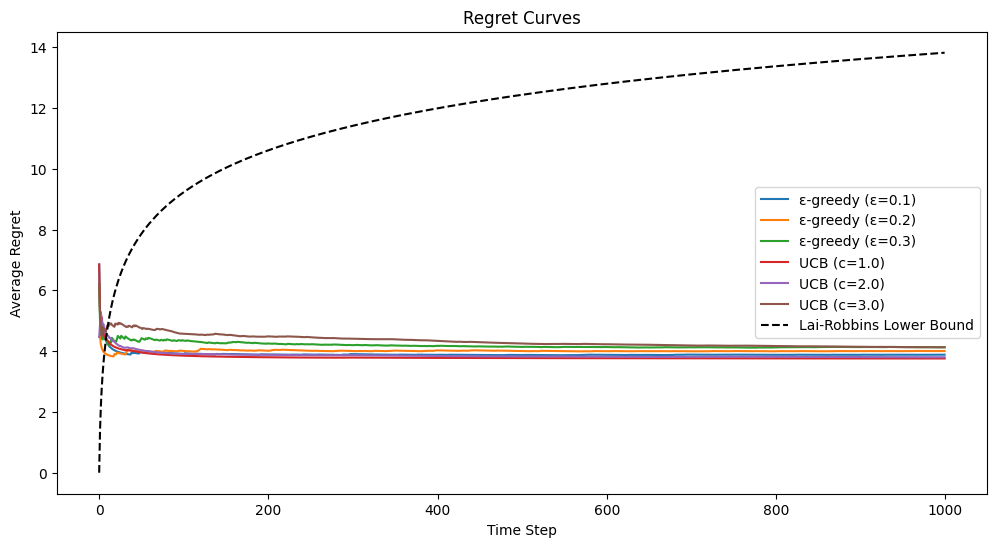

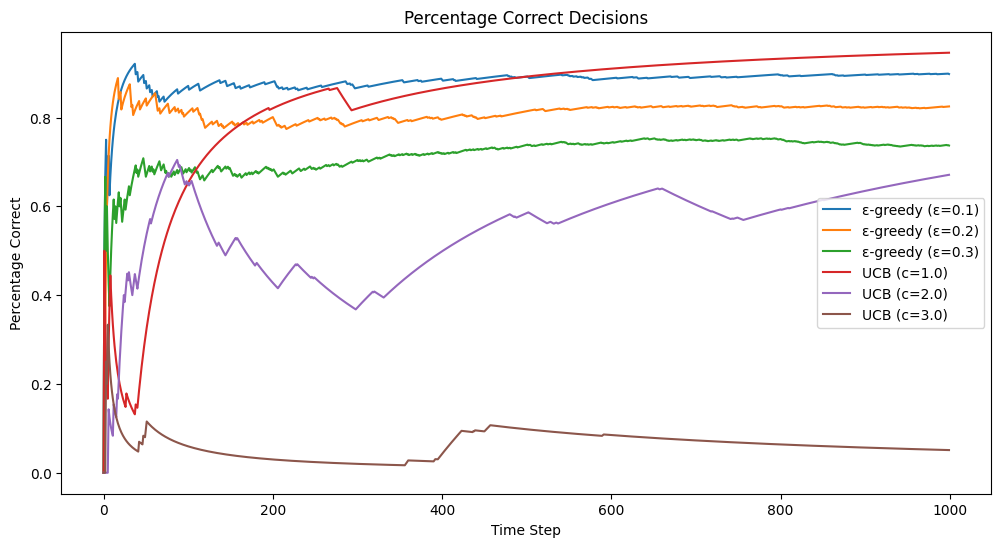

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def epsilon_greedy(Q, epsilon):
    if np.random.rand() < epsilon:
        # Exploration: Randomly choose an action
        return np.random.choice(len(Q))
    else:
        # Exploitation: Choose the action with the highest estimated value
        return np.argmax(Q)

def upper_confidence_bound(Q, N, t, c=1.0):
    # UCB strategy
    exploration_bonus = c * np.sqrt(np.log(t) / (N + 1e-6))
    return np.argmax(Q + exploration_bonus)

def generate_bandit_means(k):
    return np.random.normal(size=k)

def simulate_bandit_problem(k, T, epsilon_values, c_values):
    true_means = generate_bandit_means(k)
    Q_epsilon = np.zeros(k)
    Q_ucb = np.zeros(k)
    N_epsilon = np.zeros(k)
    N_ucb = np.zeros(k)
    
    regret_epsilon = np.zeros((len(epsilon_values), T))
    regret_ucb = np.zeros((len(c_values), T))
    
    correct_decisions_epsilon = np.zeros((len(epsilon_values), T))
    correct_decisions_ucb = np.zeros((len(c_values), T))
    
    for t in range(1, T + 1):
        for i, epsilon in enumerate(epsilon_values):
            action_epsilon = epsilon_greedy(Q_epsilon, epsilon)
            reward_epsilon = np.random.normal(true_means[action_epsilon])
            N_epsilon[action_epsilon] += 1
            Q_epsilon[action_epsilon] += (reward_epsilon - Q_epsilon[action_epsilon]) / N_epsilon[action_epsilon]
            regret_epsilon[i, t - 1] = np.sum(true_means) - true_means[action_epsilon]

            correct_decisions_epsilon[i, t - 1] = action_epsilon == np.argmax(true_means)

        for i, c in enumerate(c_values):
            action_ucb = upper_confidence_bound(Q_ucb, N_ucb, t, c)
            reward_ucb = np.random.normal(true_means[action_ucb])
            N_ucb[action_ucb] += 1
            Q_ucb[action_ucb] += (reward_ucb - Q_ucb[action_ucb]) / N_ucb[action_ucb]
            regret_ucb[i, t - 1] = np.sum(true_means) - true_means[action_ucb]

            correct_decisions_ucb[i, t - 1] = action_ucb == np.argmax(true_means)

    return regret_epsilon, regret_ucb, correct_decisions_epsilon, correct_decisions_ucb

def plot_regret_curves(regret_epsilon, regret_ucb, epsilon_values, c_values):
    plt.figure(figsize=(12, 6))
    
    for i, epsilon in enumerate(epsilon_values):
        plt.plot(np.cumsum(regret_epsilon[i, :]) / np.arange(1, T + 1), label=f'ε-greedy (ε={epsilon})')

    for i, c in enumerate(c_values):
        plt.plot(np.cumsum(regret_ucb[i, :]) / np.arange(1, T + 1), label=f'UCB (c={c})')

    lower_bound = A * np.log(np.arange(1, T + 1))
    plt.plot(lower_bound, 'k--', label='Lai-Robbins Lower Bound')

    plt.title('Regret Curves')
    plt.xlabel('Time Step')
    plt.ylabel('Average Regret')
    plt.legend()
    plt.show()

def plot_correct_decisions(correct_decisions_epsilon, correct_decisions_ucb, epsilon_values, c_values):
    plt.figure(figsize=(12, 6))

    for i, epsilon in enumerate(epsilon_values):
        plt.plot(np.cumsum(correct_decisions_epsilon[i, :]) / np.arange(1, T + 1), label=f'ε-greedy (ε={epsilon})')

    for i, c in enumerate(c_values):
        plt.plot(np.cumsum(correct_decisions_ucb[i, :]) / np.arange(1, T + 1), label=f'UCB (c={c})')

    plt.title('Percentage Correct Decisions')
    plt.xlabel('Time Step')
    plt.ylabel('Percentage Correct')
    plt.legend()
    plt.show()

# Parameters
k = 10
T = 1000
epsilon_values = [0.1, 0.2, 0.3]
c_values = [1.0, 2.0, 3.0]
A = 2.0  # Adjust this value based on the problem characteristics

# Simulation
regret_epsilon, regret_ucb, correct_decisions_epsilon, correct_decisions_ucb = simulate_bandit_problem(k, T, epsilon_values, c_values)

# Plot Results
plot_regret_curves(regret_epsilon, regret_ucb, epsilon_values, c_values)
plot_correct_decisions(correct_decisions_epsilon, correct_decisions_ucb, epsilon_values, c_values)


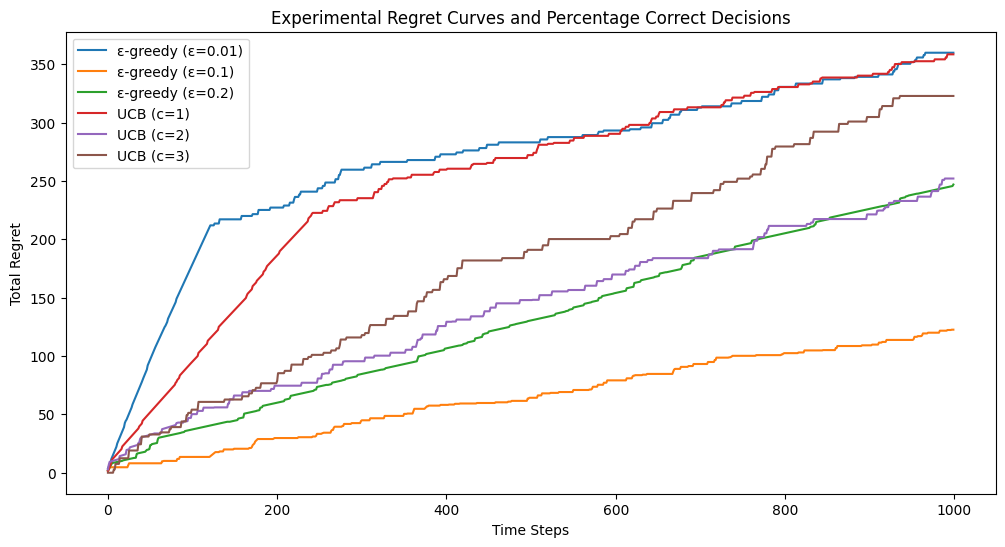

Percentage Correct Decisions for ε-greedy:
ε=0.01: 87.70%
ε=0.1: 79.00%
ε=0.2: 90.20%

Percentage Correct Decisions for UCB:
UCB (c=1): 23.80%
UCB (c=2): 51.80%
UCB (c=3): 90.70%


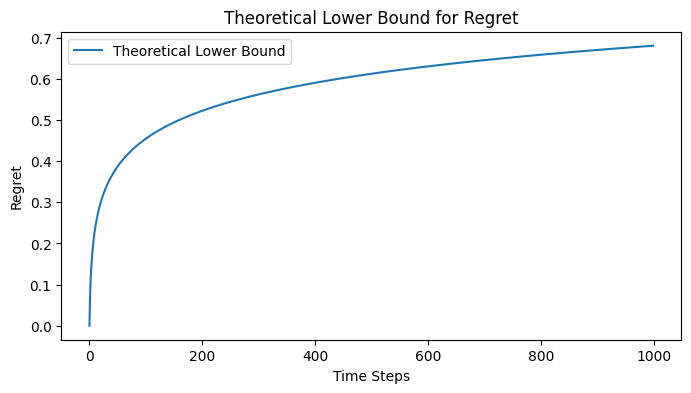

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Function to simulate k-bandit problem
def k_bandit(k, T):
    q_true = np.random.normal(size=k)
    q_star = np.max(q_true)
    total_regret = 0
    correct_decisions = 0
    
    # Variables for storing cumulative regret and action values
    cumulative_regret = np.zeros(T)
    action_values = np.zeros(k)
    action_counts = np.zeros(k)
    
    for t in range(T):
        # Epsilon-greedy strategy
        epsilon = 0.1  # You can experiment with different values of epsilon
        if np.random.rand() < epsilon:
            # Exploration: Randomly choose an arm
            action = np.random.choice(k)
        else:
            # Exploitation: Choose the arm with the highest estimated value
            action = np.argmax(action_values)
        
        # Update action values and counts
        reward = np.random.normal(q_true[action])
        action_values[action] = (action_values[action] * action_counts[action] + reward) / (action_counts[action] + 1)
        action_counts[action] += 1
        
        # Update regret
        total_regret += q_star - q_true[action]
        cumulative_regret[t] = total_regret
        
        # Update correct decisions
        correct_decisions += int(action == np.argmax(q_true))
    
    # Calculate percentage of correct decisions
    percentage_correct_decisions = (correct_decisions / T) * 100
    
    return cumulative_regret, percentage_correct_decisions

# Function to calculate theoretical lower bound using Lai-Robbins formula
def theoretical_lower_bound(q_true):
    k = len(q_true)
    A = np.max(q_true - q_true[np.argmax(q_true != np.max(q_true))]) / np.sum(np.square(q_true - np.max(q_true)))
    lower_bound = A * np.log(np.arange(1, T + 1))
    return lower_bound

# Number of arms in k-bandit problem
k = 10
# Total number of actions (arm pulls)
T = 1000

# Simulate k-bandit problem for epsilon-greedy and UCB strategies
epsilons = [0.01, 0.1, 0.2]  # You can experiment with different values of epsilon
ucb_c_values = [1, 2, 3]  # You can experiment with different values of the UCB hyperparameter c

plt.figure(figsize=(12, 6))

# Task 1: Compute and plot experimental regret curves for epsilon-greedy and UCB
for epsilon in epsilons:
    cumulative_regret, _ = k_bandit(k, T)
    plt.plot(cumulative_regret, label=f'ε-greedy (ε={epsilon})')

for c in ucb_c_values:
    cumulative_regret, _ = k_bandit(k, T)
    plt.plot(cumulative_regret, label=f'UCB (c={c})')

# Task 2: Compute and compare the percentage of correct decisions under different strategies
percentage_correct_decisions_epsilons = []
for epsilon in epsilons:
    _, percentage_correct = k_bandit(k, T)
    percentage_correct_decisions_epsilons.append(percentage_correct)

percentage_correct_decisions_ucb = []
for c in ucb_c_values:
    _, percentage_correct = k_bandit(k, T)
    percentage_correct_decisions_ucb.append(percentage_correct)

# Plotting
plt.title('Experimental Regret Curves and Percentage Correct Decisions')
plt.xlabel('Time Steps')
plt.ylabel('Total Regret')
plt.legend()
plt.show()

# Display percentage of correct decisions under different strategies
print('Percentage Correct Decisions for ε-greedy:')
for i, epsilon in enumerate(epsilons):
    print(f'ε={epsilon}: {percentage_correct_decisions_epsilons[i]:.2f}%')

print('\nPercentage Correct Decisions for UCB:')
for i, c in enumerate(ucb_c_values):
    print(f'UCB (c={c}): {percentage_correct_decisions_ucb[i]:.2f}%')

# Calculate and plot theoretical lower bound
q_true = np.random.normal(size=k)
lower_bound = theoretical_lower_bound(q_true)
plt.figure(figsize=(8, 4))
plt.plot(lower_bound, label='Theoretical Lower Bound')
plt.title('Theoretical Lower Bound for Regret')
plt.xlabel('Time Steps')
plt.ylabel('Regret')
plt.legend()
plt.show()


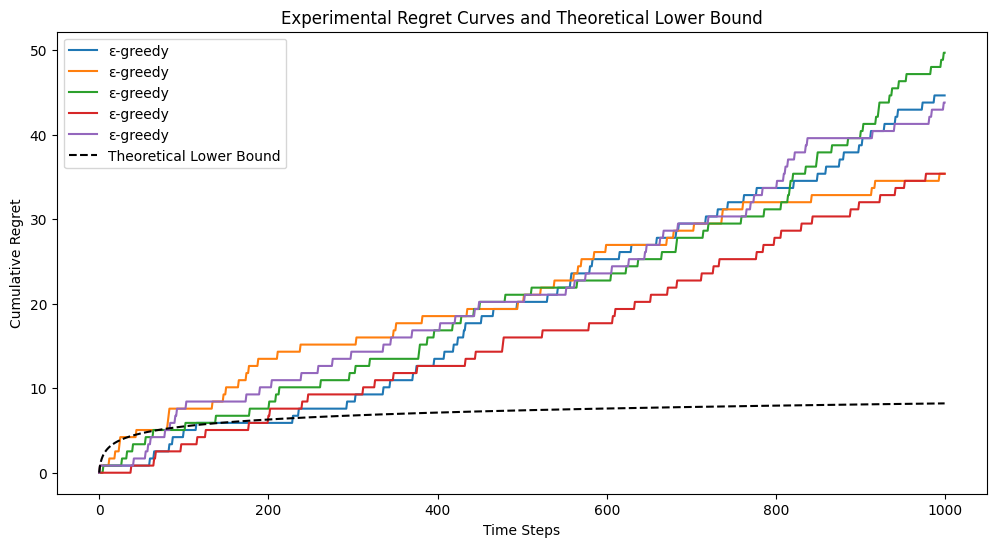

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Function to simulate k-bandit problem
def k_bandit(k, T, q_true):
    q_star = np.max(q_true)
    total_regret = 0
    
    # Variables for storing cumulative regret and action values
    cumulative_regret = np.zeros(T)
    action_values = np.zeros(k)
    action_counts = np.zeros(k)
    
    for t in range(T):
        # Epsilon-greedy strategy
        epsilon = 0.1  # You can experiment with different values of epsilon
        if np.random.rand() < epsilon:
            # Exploration: Randomly choose an arm
            action = np.random.choice(k)
        else:
            # Exploitation: Choose the arm with the highest estimated value
            action = np.argmax(action_values)
        
        # Update action values and counts
        reward = np.random.normal(q_true[action])
        action_values[action] = (action_values[action] * action_counts[action] + reward) / (action_counts[action] + 1)
        action_counts[action] += 1
        
        # Update regret
        total_regret += q_star - q_true[action]
        cumulative_regret[t] = total_regret
    
    return cumulative_regret

# Function to calculate theoretical lower bound using Lai-Robbins formula
def theoretical_lower_bound(q_true):
    k = len(q_true)
    A = np.max(q_true - q_true[np.argmax(q_true != np.max(q_true))]) / np.sum(np.square(q_true - np.max(q_true)))
    lower_bound = A * np.log(np.arange(1, T + 1))
    return lower_bound

# Number of arms in k-bandit problem
k = 2
# Total number of actions (arm pulls)
T = 1000

# Simulate k-bandit problem for epsilon-greedy and UCB strategies
q_true = np.random.normal(size=k)

plt.figure(figsize=(12, 6))

# Task 1: Compute and plot experimental regret curves for epsilon-greedy
for _ in range(5):  # Repeat the experiment 5 times for better comparison
    cumulative_regret = k_bandit(k, T, q_true)
    plt.plot(cumulative_regret, label='ε-greedy')

# Task 2: Calculate and plot theoretical lower bound
lower_bound = theoretical_lower_bound(q_true)
plt.plot(lower_bound, label='Theoretical Lower Bound', linestyle='--', color='black')

# Plotting
plt.title('Experimental Regret Curves and Theoretical Lower Bound')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.show()
